In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

zip_path = "/content/drive/MyDrive/NCKU/碩一上/AI醫療/TB_Chest.zip"
extract_path = "/content/TB_Chest_Radiography_Database"


if not os.path.exists(extract_path):
    print("⏳ 正在從 Drive 解壓縮資料集...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    print("✅ 解壓完成！")
else:
    print("資料夾已存在，跳過解壓縮。")

all_filepaths = []
all_labels = []

classes = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]

for class_name in classes:
    class_path = os.path.join(extract_path, class_name)
    files = os.listdir(class_path)
    for file in files:

        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            fpath = os.path.join(class_path, file)
            all_filepaths.append(fpath)
            all_labels.append(class_name)


full_df = pd.DataFrame({'filepaths': all_filepaths, 'labels': all_labels})

train_df, temp_df = train_test_split(full_df, train_size=0.7, shuffle=True, random_state=42, stratify=full_df['labels'])

valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=42, stratify=temp_df['labels'])

print(f"總圖片數: {len(full_df)}")
print("-" * 30)
print(f"訓練集 (Train): {len(train_df)} 張")
print(f"驗證集 (Val):   {len(valid_df)} 張")
print(f"測試集 (Test):  {len(test_df)} 張")

if not train_df.empty:
    print("\n類別分佈 (訓練集)：")
    print(train_df['labels'].value_counts())

資料夾已存在，跳過解壓縮。
總圖片數: 4200
------------------------------
訓練集 (Train): 2940 張
驗證集 (Val):   630 張
測試集 (Test):  630 張

類別分佈 (訓練集)：
labels
Normal          2450
Tuberculosis     490
Name: count, dtype: int64


In [ ]:

img_size = (256, 256)
batch_size = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

valid_generator = valid_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)


Found 2940 validated image filenames belonging to 2 classes.
Found 630 validated image filenames belonging to 2 classes.
Found 630 validated image filenames belonging to 2 classes.


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_generator.classes
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.6), 1: np.float64(3.0)}


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=1,
    min_lr=1e-5,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 解凍 ResNet 後段
base_model.trainable = True
for layer in base_model.layers[:143]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stop],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
184/184 - 115s - 627ms/step - accuracy: 0.7724 - loss: 0.4904 - val_accuracy: 0.8444 - val_loss: 0.6513 - learning_rate: 1.0000e-05
Epoch 2/10
184/184 - 72s - 389ms/step - accuracy: 0.8915 - loss: 0.2723 - val_accuracy: 0.9397 - val_loss: 0.2318 - learning_rate: 1.0000e-05
Epoch 3/10
184/184 - 72s - 389ms/step - accuracy: 0.9105 - loss: 0.2189 - val_accuracy: 0.8397 - val_loss: 0.3360 - learning_rate: 1.0000e-05
Epoch 4/10
184/184 - 72s - 390ms/step - accuracy: 0.9259 - loss: 0.1907 - val_accuracy: 0.9190 - val_loss: 0.1998 - learning_rate: 1.0000e-05
Epoch 5/10
184/184 - 71s - 388ms/step - accuracy: 0.9316 - loss: 0.1829 - val_accuracy: 0.9476 - val_loss: 0.1258 - learning_rate: 1.0000e-05
Epoch 6/10
184/184 - 71s - 388ms/step - accuracy: 0.9378 - loss: 0.1645 - val_accuracy: 0.9810 - val_loss: 0.0688 - learning_rate: 1.0000e-05
Epoch 7/10
184/184 - 72s - 389ms/step - accuracy: 0.9497 - loss: 0.1325 - val_accuracy: 0.9143 - val_loss: 0.2348 - learning_rate: 1.0000e-05
Epoch

In [10]:
test_generator.reset()
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).ravel()

true_labels = test_generator.classes

print(classification_report(true_labels, pred_labels, target_names=['Normal', 'TB']))


40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       525
          TB       0.94      0.92      0.93       105

    accuracy                           0.98       630
   macro avg       0.96      0.96      0.96       630
weighted avg       0.98      0.98      0.98       630



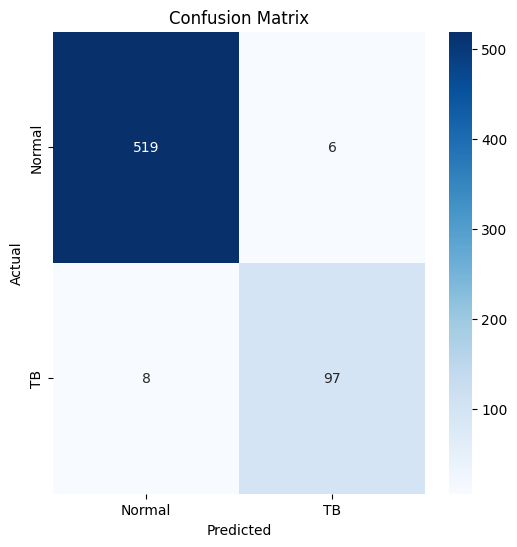

In [11]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'TB'],
    yticklabels=['Normal', 'TB']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
